# AI per trovare l'uscita in un labirinto



In [2]:
import sys
import time
from datetime import timedelta


Ricordate "strutture dati + algoritmi = software"?
La struttura dati per memorizzare il generico nodo del grafo dei possibili stati è 

In [3]:
class Nodo():
    def __init__(self, stato, genitore, azione):
        self.stato = stato
        self.genitore = genitore
        self.azione = azione

L'altra struttura dati di cui abbiamo bisogno è la struttura dati della Frontiera.
Come abbiamo visto ci sono due tipo di struttura dati che possiamo usare per la frontiera.

La pila è una struttura dati che adotta una logica Last In First Out (l'ultimo a entrare è il primo ad uscire come accade per una pila, appunto, di piatti)


In [4]:
class FrontieraPila():
    def __init__(self):
        self.frontiera = []

    def aggiungiStato(self, nodo):
        self.frontiera.append(nodo)

    def contieneStato(self, stato):
        return any(nodo.stato == stato for nodo in self.frontiera)

    def eVuota(self):
        return len(self.frontiera) == 0

    def rimuoviStato(self):
        if self.eVuota():
            raise Exception("Frontiera vuota")
        else:
            nodo = self.frontiera[-1]
            self.frontiera = self.frontiera[:-1]
            return nodo


In [7]:
f = FrontieraPila()
f.eVuota()

True

In [8]:
f = FrontieraPila()
f.aggiungiStato("Pippo")
f.aggiungiStato("Pluto")
f.aggiungiStato("Topolino")
f.eVuota()

False

In [9]:
f.rimuoviStato()

'Topolino'

In [10]:
f.eVuota()

False

In [11]:
f.rimuoviStato()

'Pluto'

In [12]:
f.rimuoviStato()

'Pippo'

In [13]:
f.eVuota()

True

Con una pila per frontiera si realizza un algoritmo Depth First Search (DFS) e, come vedremo nel seguito, si ha che l'AI cerca prima di visitare ogni cammino fino alla fine, ovvero alla constatazione che non c'è una uscita in quel cammino, prima di cercare in un altro cammino.

L'altra struttura dati è la coda. La coda è una struttura dati che adotta una logica First In First Out (il primo a entrare è il primo ad uscire come accade per una coda, appunto, allo sportello della posta) 

In [14]:
class FrontieraCoda(FrontieraPila):

    def rimuoviStato(self):
        if self.eVuota():
            raise Exception("Frontiera vuota")
        else:
            nodo = self.frontiera[0]
            self.frontiera = self.frontiera[1:]
            return nodo

Con una coda per frontiera si realizza un algoritmo Breadth First Search (BFS) e, come vedremo nel seguito, si ha che l'AI ad ogni diramazione cerca di visitare i nodi più vicini prima di addentrarsi in un qualunque cammino fino a trovare l'uscita o decidere che non c'è uscita.

Adesso vediamo come è fatta la classe Labirinto che contiene la descrizione del nostro problema da risolvere con l'AI

In [19]:
class Labirinto():

    def __init__(self, nomeFile):
        
        # legge il file del labirinto e imposta altezza e larghezza del labirinto
        with open(nomeFile) as f:
            contenuti = f.read()

        # Verifica che il file contenga almeno uno stato inizial (= un ingresso) e uno finale (= una uscita)
        if contenuti.count("A") != 1:
            raise Exception("Un labirinto deve avere esattamente un punto di partenza")
        if contenuti.count("B") != 1:
            raise Exception("Un labirinto deve avere esattamente un obiettivo")

        # Calcola l'altezza e la larghezza del labirinto
        contenuti = contenuti.splitlines()
        self.altezza = len(contenuti)
        self.larghezza = max(len(line) for line in contenuti)

        # tiene traccia dei muri del labirinto
        self.muri = []
        for i in range(self.altezza):
            riga = []
            for j in range(self.larghezza):
                try:
                    if contenuti[i][j] == "A":
                        self.start = (i, j)
                        riga.append(False)
                    elif contenuti[i][j] == "B":
                        self.goal = (i, j)
                        riga.append(False)
                    elif contenuti[i][j] == " ":
                        riga.append(False)
                    else:
                        riga.append(True)
                except IndexError:
                    riga.append(False)
            self.muri.append(riga)

        self.soluzione = None


    def stampaLabirinto(self):
        soluzione = self.soluzione[1] if self.soluzione is not None else None
        print()
        for i, riga in enumerate(self.muri):
            for j, col in enumerate(riga):
                if col:
                    print("█", end="")
                elif (i, j) == self.start:
                    print("A", end="")
                elif (i, j) == self.goal:
                    print("B", end="")
                elif soluzione is not None and (i, j) in soluzione:
                    print("*", end="")
                else:
                    print(" ", end="")
            print()
        print()


    def nodiVicini(self, stato):
        riga, col = stato
        candidati = [
            ("su", (riga - 1, col)),
            ("giu", (riga + 1, col)),
            ("sin", (riga, col - 1)),
            ("des", (riga, col + 1))
        ]

        risultato = []
        for azione, (r, c) in candidati:
            if 0 <= r < self.altezza and 0 <= c < self.larghezza and not self.muri[r][c]:
                risultato.append((azione, (r, c)))
        return risultato


    def risolvi(self,frontiera):
        """Finds a soluzione to maze, if one exists."""
        
        # Keep track of number of statos explored
        self.numeroStatiEsplorati = 0

        # Initialize frontier to just the starting position
        start = Nodo(stato=self.start, genitore=None, azione=None)
        # frontier = FrontieraPila()
        frontiera.aggiungiStato(start)

        # Inizializzazione di un set di stati esplorati al momento vuoto
        self.statiEsplorati = set()

        # Continua a eseguire in ciclo finché non si trova una soluzione o il problema non è risolvibile
        while True:

            # Se non c'è nulla nella frontiera vuol dire che il problema non è risolvibile. 
            # Ovvero, non c'è un cammino tra start e goal!
            if frontiera.eVuota():
                raise Exception("Non esiste una soluzione")

            # Sceglie un nodo dalla froniera
            nodo = frontiera.rimuoviStato()
            self.numeroStatiEsplorati += 1

            # Se il nodo estratto è il nodo goal allora abbiamo trovato il nodo di arrivo e risolto il problema
            if nodo.stato == self.goal:
                azioni = []
                celle = []
                # ripercorre il cammino al contrario dal goal verso lo stato start per creare il cammino
                # che porta dallo start al goal. Ovvero, la soluzione.
                while nodo.genitore is not None:
                    azioni.append(nodo.azione)
                    celle.append(nodo.stato)
                    nodo = nodo.genitore
                # Siccome ha costruito il cammino soluzione in direzione inversa, ovvero da goal a start 
                # per avere il cammino orientato in modo corretto deve invertire sia la lista degli stati
                # che quella delle azioni
                azioni.reverse()
                celle.reverse()
                # Quindi memorizza la lista degli stati e la lista delle azioni da intraprendere nell'attributo
                # soluzione della classe Labirinto
                self.soluzione = (azioni, celle)
                return

            # Altrimenti marchiamo il nodo estratto come esplorato
            self.statiEsplorati.add(nodo.stato)

            # E aggiungiamo i nodi vicini alla frontiera
            for azione, stato in self.nodiVicini(nodo.stato):
                if not frontiera.contieneStato(stato) and stato not in self.statiEsplorati:
                    child = Nodo(stato=stato, genitore=nodo, azione=azione)
                    frontiera.aggiungiStato(child)


    def produciImmagineLabirinto(self, nomeFile, mostraSoluzione=True, mostraStatiEsplorati=False):
        from PIL import Image, ImageDraw
        dimensioneCella = 50
        dimensioneBordoCella = 2

        # Crea una immagine bianca (una canvas = tela)
        img = Image.new(
            "RGBA",
            (self.larghezza * dimensioneCella, self.altezza * dimensioneCella),
            "black"
        )
        draw = ImageDraw.Draw(img)

        soluzione = self.soluzione[1] if self.soluzione is not None else None
        for i, riga in enumerate(self.muri):
            for j, col in enumerate(riga):

                # Muri
                if col:
                    fill = (40, 40, 40)

                # Stato iniziale
                elif (i, j) == self.start:
                    fill = (255, 0, 0)

                # Goal
                elif (i, j) == self.goal:
                    fill = (0, 171, 28)

                # Soluzione
                elif soluzione is not None and mostraSoluzione and (i, j) in soluzione:
                    fill = (220, 235, 113)

                # Stati esplorati
                elif soluzione is not None and mostraStatiEsplorati and (i, j) in self.statiEsplorati:
                    fill = (212, 97, 85)

                # Cella vuota
                else:
                    fill = (237, 240, 252)

                # Disegna cella
                draw.rectangle(
                    ([(j * dimensioneCella + dimensioneBordoCella, i * dimensioneCella + dimensioneBordoCella),
                      ((j + 1) * dimensioneCella - dimensioneBordoCella, (i + 1) * dimensioneCella - dimensioneBordoCella)]),
                    fill=fill
                )

        img.save(nomeFile)



Adesso possiamo testare la nostra AI con un labirinto.
Per come abbiamo scritto la nostra classe Labirinto, il file che contiene un labirinto deve avere tante righe e tante colonne per quante righe e colonne vogliamo sia formato il nostro labirinto.
In ogni labirinto ci deve essere almeno un punto di partenza marcato con il carattere A e almeno una uscita o destinazione marcata con il carattere B.
I muri sono indicati con un carattere cancelletto menter i passaggi liberi con uno spazio. 
Ad esempio:
```
#####B#
##### #
A     #
#### ##
     ##
#######
```
è un laborinto di 6 righe per 7 colonne. Questo esempio è memorizzato nel file labirinto1.txt

Mettiamo alla prova la nostra AI con questo labirinto.
Carichiamo il labirinto labirinto1.txt nella nostra AI e stampiamo il labirinto.

In [24]:
l = Labirinto("labirinto1.txt")
print("Labirinto:")
l.stampaLabirinto()

Labirinto:

█████B█
█████ █
A     █
████ ██
     ██
███████



Adesso cerchiamo una soluzione con una frontiera pila per adottare un approccio DFS. Quindi, andiamo in profondità prima:

In [17]:
print("Sto cercando una soluzione con una frontiera pila (DFS)...")
tempoIniziale = time.time_ns()
l.risolvi(FrontieraPila())
print("Numero di stati esplorati : ", l.numeroStatiEsplorati)
tempoImpiegato = time.time_ns() - tempoIniziale
msg = "L'esecuzione del codice ha richiesto : %s microsecondi (Wall clock time)" % timedelta(microseconds=round(tempoImpiegato/1000))
print(msg)    
print("Soluzione trovata : ")
l.stampaLabirinto()
l.produciImmagineLabirinto("labirintoPila.png", mostraStatiEsplorati=False)

Sto cercando una soluzione con una frontiera pila (DFS)...
Numero di stati esplorati :  8
L'esecuzione del codice ha richiesto : 0:00:00 microsecondi (Wall clock time)
Soluzione trovata : 

█████B█
█████*█
A*****█
████ ██
     ██
███████



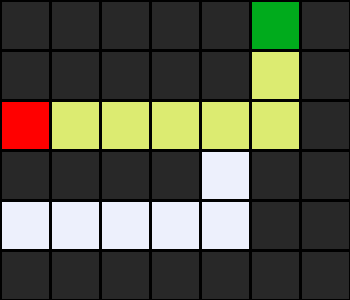

In [25]:
from IPython.display import Image
Image(filename='labirintoPila.png')

Chiediamo alla nostra AI di usare una frontiera coda (BFS). Ovvero, diciamo alla nostra AI di visitare prima i nodi più vicini prima di avventurarsi in profondità: 

In [26]:
print("Sto cercando una soluzione con una frontiera coda (BFS)...")
tempoIniziale = time.time_ns()
l.risolvi(FrontieraCoda())
print("Numero di stati esplorati : ", l.numeroStatiEsplorati)
tempoImpiegato = time.time_ns() - tempoIniziale
msg = "L'esecuzione del codice ha richiesto : %s microsecondi (Wall clock time)" % timedelta(microseconds=round(tempoImpiegato/1000))
print(msg)    
print("Soluzione trovata : ")
l.stampaLabirinto()
l.produciImmagineLabirinto("labirintoCoda.png", mostraStatiEsplorati=False)

Sto cercando una soluzione con una frontiera coda (BFS)...
Numero di stati esplorati :  11
L'esecuzione del codice ha richiesto : 0:00:00.005036 microsecondi (Wall clock time)
Soluzione trovata : 

█████B█
█████*█
A*****█
████ ██
     ██
███████



possiamo vedere con una grafica più accattivante il risultato:

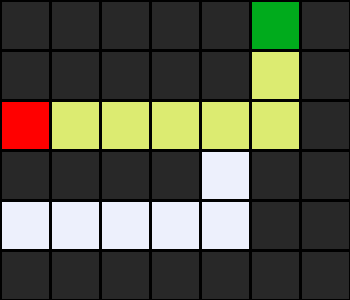

In [27]:
Image(filename='labirintoCoda.png')

Apparentemente, il risultato è lo stesso. MA, se guardiamo bene quasta volta l'AI ha vistato 11 stati prima di trovare lo stato finale mentra nel caso precedente la soluzione era stata trovata visitando solo 8 stati.
Possiamo vedere gli stati che l'AI ha visitato mettendo a True lo switch mostraStatiEsplorati del metodo produciImmagineLabirinto. Vediamo:


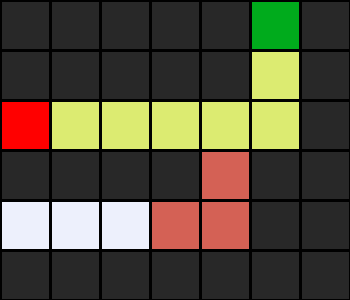

In [51]:
l.produciImmagineLabirinto("labirintoCoda.png", mostraStatiEsplorati=True)
Image(filename='labirintoCoda.png')


Come possiamo vedere qui sopra, l'AI ha esplorato i tre stati in rosso "inutilmente". Quindi, in questo caso e ribadisco inquesto caso, bFS si comporta peggio di DFS.
Vediamo un altro esempio con il file labirinto2.txt:


Sto cercando una soluzione con una frontiera pila (DFS)...
Numero di stati esplorati :  194
L'esecuzione del codice ha richiesto : 0:00:00.001000 microsecondi (Wall clock time)
Soluzione trovata : 


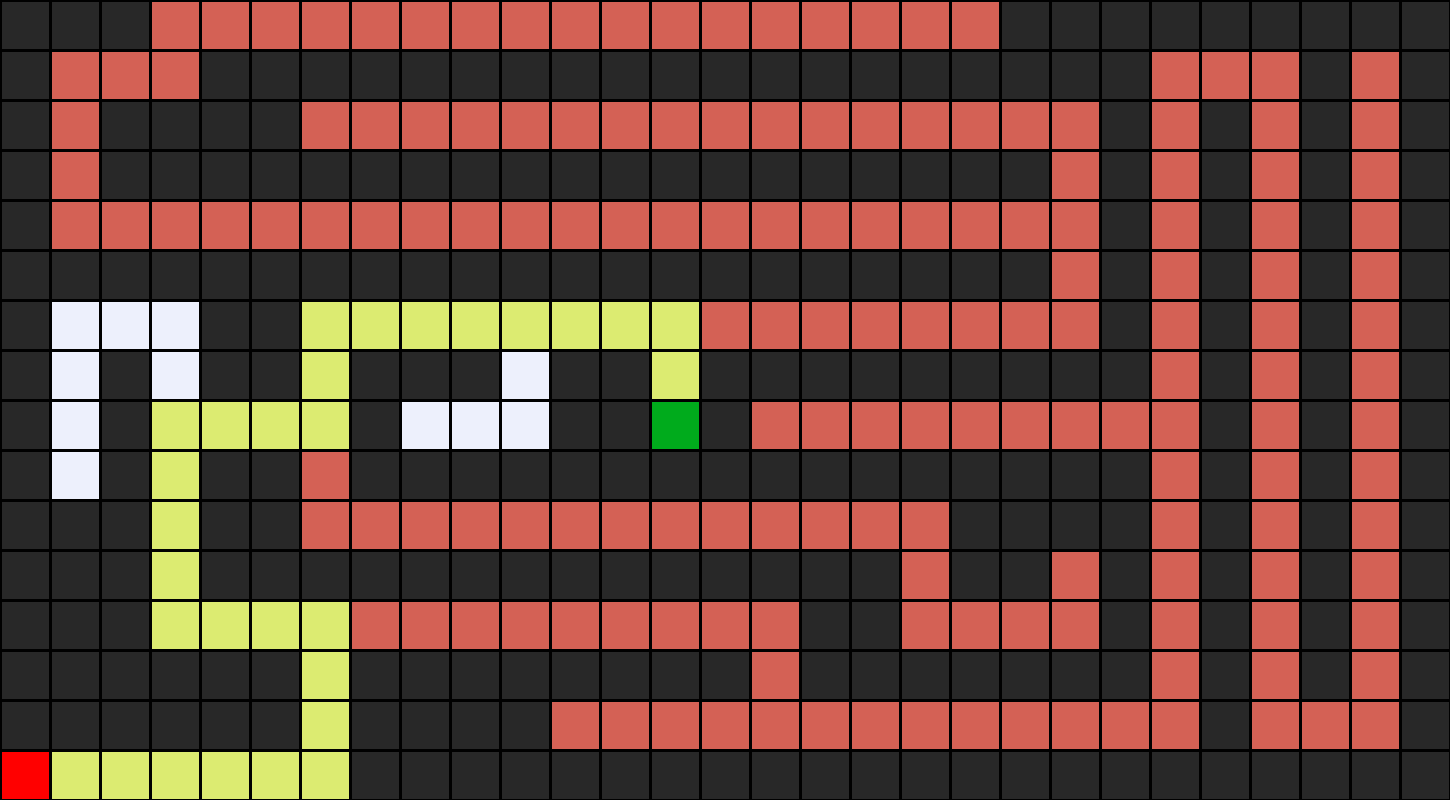

In [61]:
l = Labirinto("labirinto2.txt")
print("Sto cercando una soluzione con una frontiera pila (DFS)...")
tempoIniziale = time.time_ns()
l.risolvi(FrontieraPila())
print("Numero di stati esplorati : ", l.numeroStatiEsplorati)
tempoImpiegato = time.time_ns() - tempoIniziale
msg = "L'esecuzione del codice ha richiesto : %s microsecondi (Wall clock time)" % timedelta(microseconds=round(tempoImpiegato/1000))
print(msg)    
print("Soluzione trovata : ")
l.produciImmagineLabirinto("labirintoPila.png", mostraStatiEsplorati=True)
Image(filename='labirintoPila.png')

Sto cercando una soluzione con una frontiera coda (BFS)...
Numero di stati esplorati :  77
L'esecuzione del codice ha richiesto : 0:00:00 microsecondi (Wall clock time)
Soluzione trovata : 


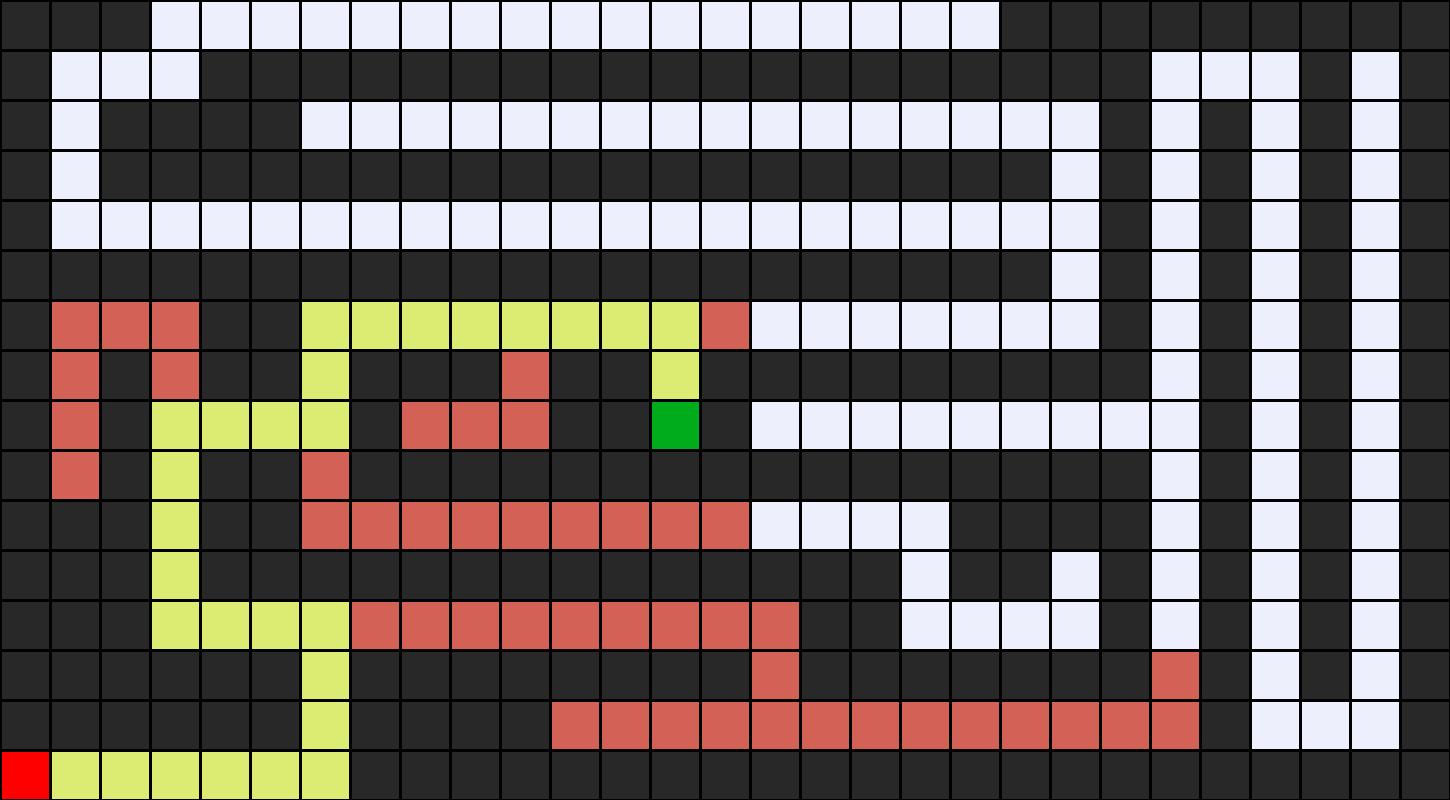

In [62]:
l = Labirinto("labirinto2.txt")
print("Sto cercando una soluzione con una frontiera coda (BFS)...")
tempoIniziale = time.time_ns()
l.risolvi(FrontieraCoda())
print("Numero di stati esplorati : ", l.numeroStatiEsplorati)
tempoImpiegato = time.time_ns() - tempoIniziale
msg = "L'esecuzione del codice ha richiesto : %s microsecondi (Wall clock time)" % timedelta(microseconds=round(tempoImpiegato/1000))
print(msg)    
print("Soluzione trovata : ")
l.produciImmagineLabirinto("labirintoCoda.png", mostraStatiEsplorati=True)
Image(filename='labirintoCoda.png')

Come possiamo vedere qui sopra, in questo caso e ribadisco in questo caso, BFS si comporta mooolto meglio di DFS con soli 77 nodi visitati invece che 194.